# Import Libraries

In [1]:
# numpy
import numpy as np

# pandas
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt

# Statsmodel
from statsmodels.tsa.stattools import adfuller

# sklearn 
from sklearn.metrics import mean_squared_error

# Load Data

In [2]:
# Load dataset 
# 
data = pd.Series.from_csv(path='Data/robberies.csv', header=0)

# split dataset
split_point = len(data) - 10

# dataset (observation from year 1966 to 1974)
# validation_data (observations of year 1975)
dataset , validation_data = data[0:split_point], data[split_point:]

/home/dexter/anaconda3/envs/kaggle/lib/python3.6/site-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


### Data Preparation: We have monthly dataset for 9 years (1966-1975), we split the dataset into two parts 
1- dataset (observation from year 1966 to 1974), will further split this into train and test. <br> 2- validation_data (observations of year 1975), will take this as a development set.

# Persistance Model (For Baseline RMSE)

In [3]:
# prepare data for persistence model

split_point = int(len(dataset) * 0.5)
train, test = dataset[0: split_point].values.astype('float32'), dataset[split_point:].values.astype('float32')

In [4]:
# walk-forward validation model
history = [i for i in train]

In [5]:
predictions = []
for i in range(len(test)):
    
    # get prediction
    y_pred = history[-1]
    predictions.append(y_pred)
    
    # observed
    y_true = test[i]
    history.append(y_true)
    print('Predicted: %.2f, Expected: %.3f' % (y_pred, y_true))
    
print('\nBaseline RMSE : %.2f' % (np.sqrt(mean_squared_error(test, predictions))))

Predicted: 125.00, Expected: 155.000
Predicted: 155.00, Expected: 190.000
Predicted: 190.00, Expected: 236.000
Predicted: 236.00, Expected: 189.000
Predicted: 189.00, Expected: 174.000
Predicted: 174.00, Expected: 178.000
Predicted: 178.00, Expected: 136.000
Predicted: 136.00, Expected: 161.000
Predicted: 161.00, Expected: 171.000
Predicted: 171.00, Expected: 149.000
Predicted: 149.00, Expected: 184.000
Predicted: 184.00, Expected: 155.000
Predicted: 155.00, Expected: 276.000
Predicted: 276.00, Expected: 224.000
Predicted: 224.00, Expected: 213.000
Predicted: 213.00, Expected: 279.000
Predicted: 279.00, Expected: 268.000
Predicted: 268.00, Expected: 287.000
Predicted: 287.00, Expected: 238.000
Predicted: 238.00, Expected: 213.000
Predicted: 213.00, Expected: 257.000
Predicted: 257.00, Expected: 293.000
Predicted: 293.00, Expected: 212.000
Predicted: 212.00, Expected: 246.000
Predicted: 246.00, Expected: 353.000
Predicted: 353.00, Expected: 339.000
Predicted: 339.00, Expected: 308.000
P

### Analysis (Persistance Model): 
We got RMSE value of <b>52.12 </b> which will act as a baseline value for improvement of ARIMA model.

# Data Analysis

## Summary Statistics

In [6]:
dataset.describe()

count    108.000000
mean     177.703704
std      116.231260
min       29.000000
25%       76.250000
50%      149.000000
75%      276.750000
max      487.000000
Name: Robberies, dtype: float64

## Line Plot

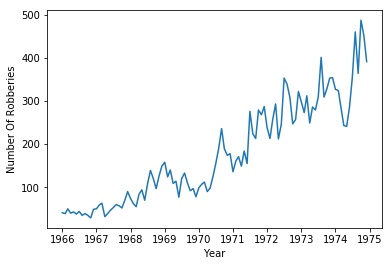

In [7]:
plt.plot(dataset)
plt.xlabel('Year')
plt.ylabel('Number Of Robberies')
plt.show()

### Analysis (Line Plot): Following observations can be made from above line plot
1- An increasing trend in observed from year to year. We will detrend it .<br>
2- Data is not stationary seems like it has varying mean and variance over time (years). We will remove seasonality .<br>
3- Large fluctions are observed from year to year. <br>
    * Earlier year posess less fluctuations .
    * Later years posess more fluctuations.

## Density Plot

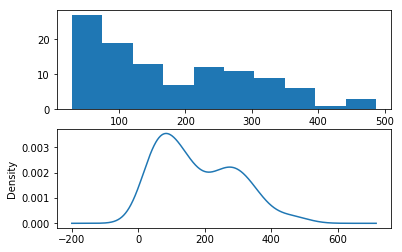

In [8]:
plt.figure(1)
plt.subplot(211)
plt.hist(dataset)
plt.subplot(212)
dataset.plot(kind='kde')
plt.show()

### Analysis (Density Plot): Following observations can be made from above Density plots
1- The histogram shows exponential distribution | long tailed towards right. This can be removed using log power transform. <br>
2- The density plot shows a bimodal distribution. <br>

## Box and Whisker Plot

/home/dexter/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


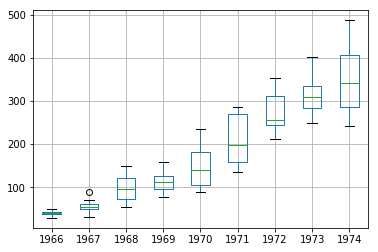

In [9]:
# Groupby year
dataset_gp_byyear = dataset.groupby(pd.TimeGrouper('A'))

# Create a dataframe of groupby values
year = pd.DataFrame()
for date, monthly_values in dataset_gp_byyear:
    year[date.year] = monthly_values.values
    
# Plot Boxplot
year.boxplot()
plt.show()

### Analysis (Boxplot): 
#### Following observation can be made from above boxplot :
1- The yearwise change in distribution shows that trend may not be linear. <br>

# ARIMA MODEL

## First lets do a statistical stationarity test (ADF test) on the dataset

In [10]:
# ADF test
